# Splitting image on harddisk script

In [79]:
from PIL import Image
import numpy as np
from patchify import patchify
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import tensorflow as tf
import tensorflow_io as tfio


In [12]:
source_path = '../raw_data/aerial_images_inria1358/AerialImageDataset'
save_path = '../raw_data/aerial_images_inria1358/patches'

In [95]:
def make_patches(source_path, save_path, set):
    subfolders = ['images']
    if set == 'train':
        subfolders.append('gt')
    
    for subfolder in subfolders:
        load_path = f'{source_path}/{set}/{subfolder}'
        save_path_n = f'{save_path}/{set}/{subfolder}'
        # Check whether the specified path exists or not
        isExist = os.path.exists(save_path_n)
        if not isExist:
            os.makedirs(save_path_n)
        print("-"*10)
        print(f" Iterating through folder: {subfolder}")
        print("-"*10)
        
        dimensions = (200,200) if subfolder == "gt" else (200,200,3)
        
        for filename in tqdm(os.listdir(load_path)):
            im = Image.open(f'{load_path}/{filename}')
            imarray = np.array(im)
            patches = patchify(imarray, dimensions, step=200)
            for i, row in enumerate(patches):
                for j, col in enumerate(row):
                    if subfolder == "gt":
                        im = Image.fromarray(col)
                    else:
                        im = Image.fromarray(col[0])
                    im.save(f'{save_path_n}/{filename}__{i}__{j}.tiff')

In [44]:
# Takes a while
make_patches(source_path, save_path, set='test')

----------
 Iterating through folder: images
----------


100%|██████████| 180/180 [02:34<00:00,  1.16it/s]


In [96]:
# Takes a while
make_patches(source_path, save_path, set='train')

----------
 Iterating through folder: images
----------


100%|██████████| 180/180 [02:18<00:00,  1.30it/s]


----------
 Iterating through folder: gt
----------


100%|██████████| 180/180 [00:41<00:00,  4.29it/s]


In [62]:
def show_full_image_split(test_image_name, mask=False):
    path = f"{save_path}/train/gt" if mask else f"{save_path}/train/images" 
    train_images = os.listdir(f"{save_path}/train/images")
    
    filtered_train_images = [fname for fname in train_images if fname.__contains__(test_image_name)]
    plt.figure(figsize=(15, 15))
    plt.title(f"Image: {test_image_name}")
    count = 0
    for r in tqdm(range(25)):
        for c in range(25):
            ax = plt.subplot(25, 25, count+1)
            ax.set_xticks([])
            ax.set_yticks([])
            if mask:
                plt.imshow(Image.open(f"{path}/{test_image_name}__{r}__{c}.tiff"), cmap="gray")
            else:
                plt.imshow(Image.open(f"{path}/{test_image_name}__{r}__{c}.tiff"))
            count += 1

In [81]:
def show_mask_comparison(file_name):
    mask_path = f"{save_path}/train/gt/{file_name}"
    img_path = f"{save_path}/train/images/{file_name}"
    fig, ax = plt.subplots(nrows=1, ncols=2)
    ax[0].imshow(Image.open(img_path))
    ax[0].set_title("Original Image")
    
    ax[1].imshow(Image.open(mask_path), cmap="gray")
    ax[1].set_title("Original Mask")
    print(mask_path)
    print(img_path)

In [121]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(display_list[i])
  plt.show()

../raw_data/aerial_images_inria1358/patches/train/gt/austin1.tif__0__10.tiff
../raw_data/aerial_images_inria1358/patches/train/images/austin1.tif__0__10.tiff


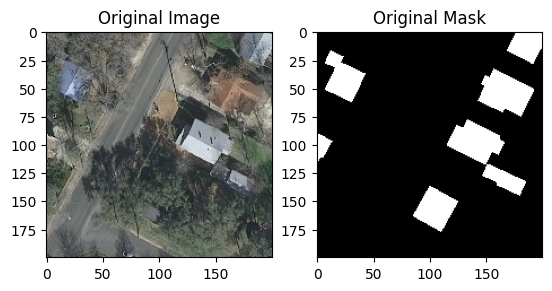

In [82]:
show_mask_comparison("austin1.tif__0__10.tiff")

100%|██████████| 25/25 [00:05<00:00,  4.74it/s]


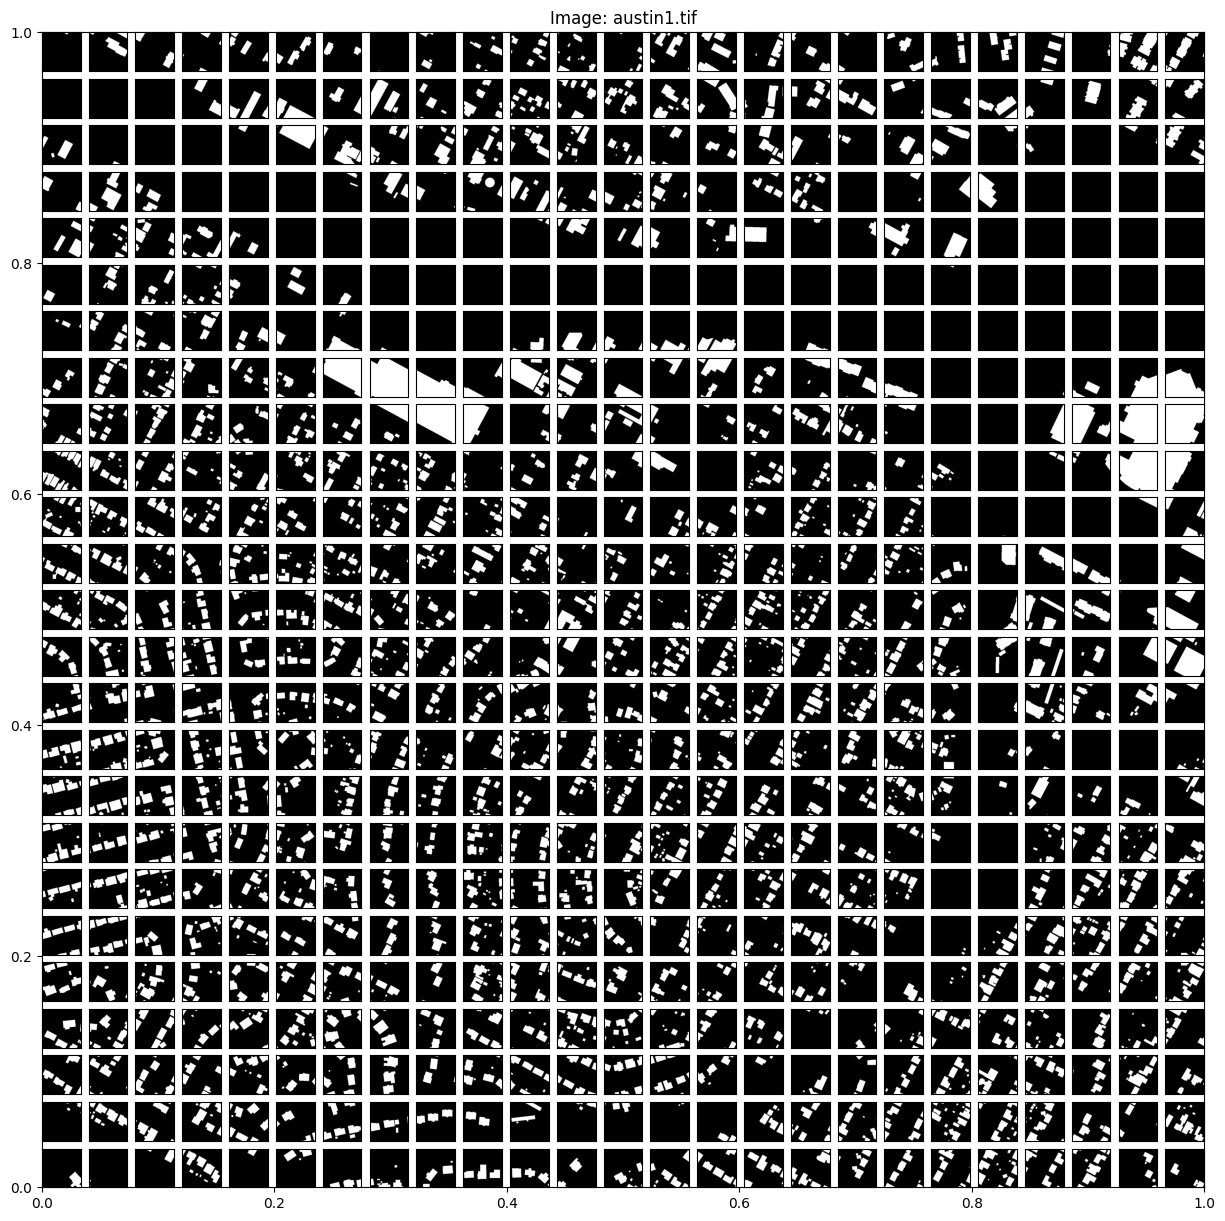

In [63]:
show_full_image_split("austin1.tif", mask=True)

In [80]:
def load_and_preprocess_data(image_path, mask_path):
    # Load and preprocess the image
    image = tf.io.read_file(image_path)
    image = tfio.experimental.image.decode_tiff(image)
    image = image/255
    image = tf.pad(image, [[10,10], [10,10], [0,0]], mode='CONSTANT', constant_values=-1)
            
    
    # Load and preprocess the mask image
    mask = tf.io.read_file(mask_path)
    mask = tfio.experimental.image.decode_tiff(mask)
    mask = mask/255
    mask = tf.pad(mask, [[10,10], [10,10], [0,0]], mode='CONSTANT', constant_values=-1)

    return image, mask

In [97]:
img_path = "../raw_data/aerial_images_inria1358/patches/train/images/austin1.tif__0__10.tiff"
mask_path = "../raw_data/aerial_images_inria1358/patches/train/gt/austin1.tif__0__10.tiff"

image, mask = load_and_preprocess_data(img_path, mask_path)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


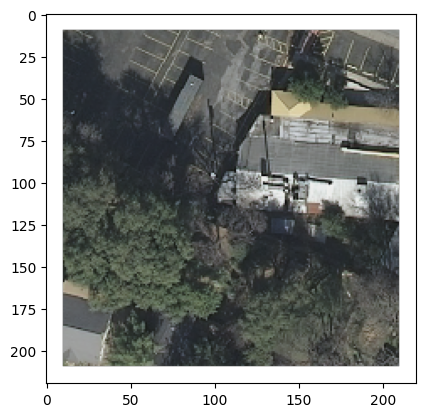

In [118]:
plt.imshow(image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


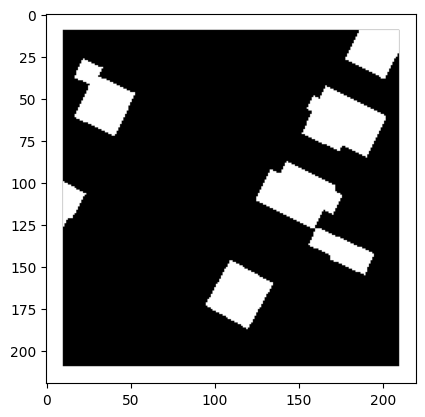

In [87]:
plt.imshow(mask)

In [98]:
image_dir = f'{save_path}/train/images'
mask_dir = f'{save_path}/train/gt'

image_paths = [os.path.join(image_dir, filename) for filename in os.listdir(image_dir)]
mask_paths = [os.path.join(mask_dir, filename) for filename in os.listdir(mask_dir)]

In [107]:
elements = len(image_paths)

test_ratio = 0.2

test_size = int(test_ratio * elements)

In [108]:
dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
dataset = dataset.map(load_and_preprocess_data)

In [109]:
train_dataset = dataset.skip(test_size)
test_dataset = dataset.take(test_size)

In [112]:
train_batches = (train_dataset.cache()
                 .shuffle(1000)
                 .batch(64)
                 .repeat()).prefetch(buffer_size=tf.data.AUTOTUNE)

test_batches = test_dataset.batch(64)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


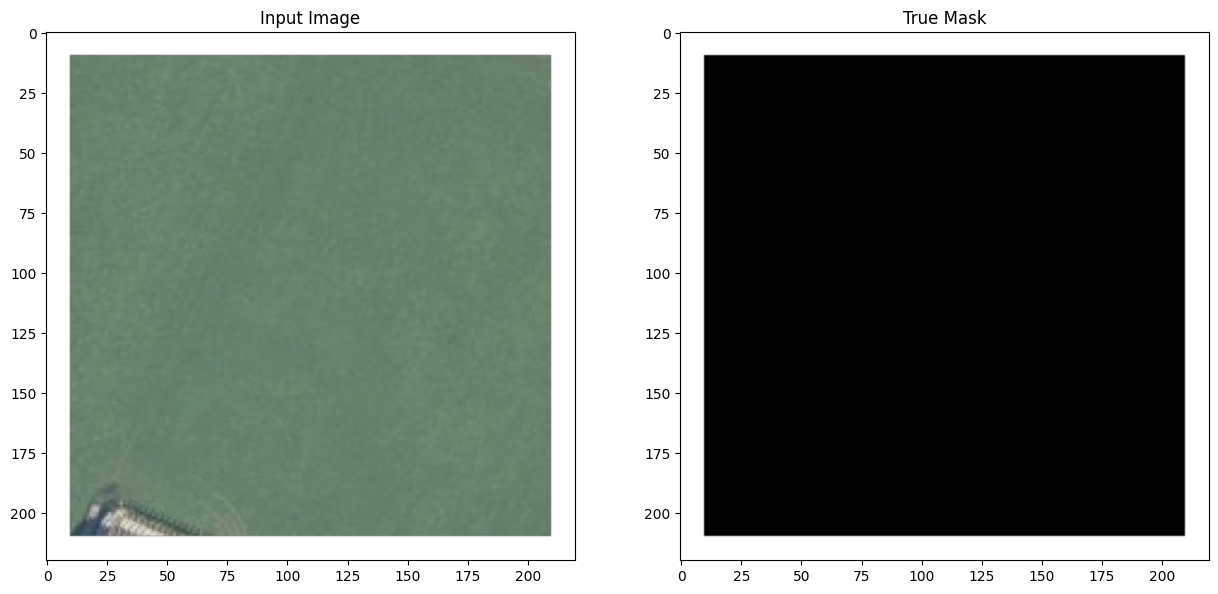

2023-09-20 17:25:50.552554: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


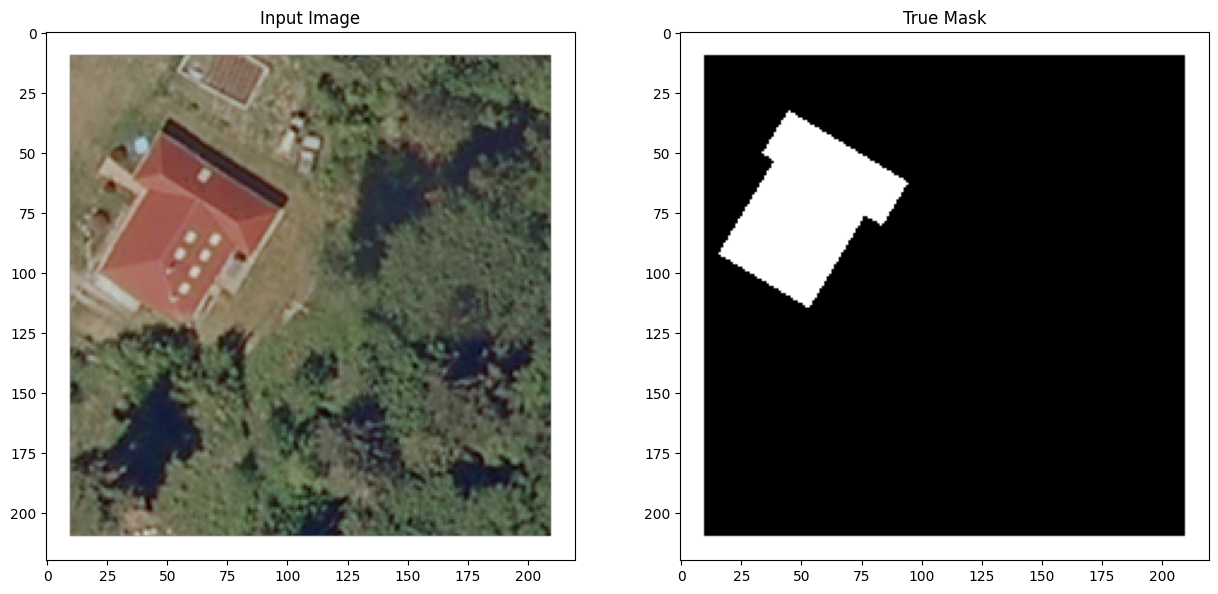

In [122]:
for images, masks in train_batches.take(2):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


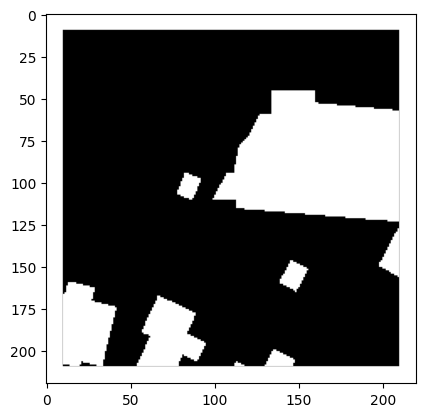

In [105]:
plt.imshow(mask)

# Splitting image in tensorflow RAM

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_io as tfio
import matplotlib.pyplot as plt
import os

2023-09-19 15:59:40.077349: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [20]:
class TIFImageGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_dir, mask_dir, batch_size, img_size):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.batch_size = batch_size
        self.img_size = img_size
        self.image_filenames = os.listdir(image_dir)

    def __len__(self):
        return len(self.image_filenames) // self.batch_size

    def __getitem__(self, index):
        batch_files = self.image_filenames[index * self.batch_size:(index + 1) * self.batch_size]
        X = []  # 3 channels for RGB
        # y = np.zeros((self.batch_size, *self.img_size, 1))  # 1 channel for grayscale
        
        first_iteration = True
        for file in batch_files:
            tensor = tf.io.read_file(f'{self.image_dir}/{file}')
            tensor = tfio.experimental.image.decode_tiff(tensor)
            tensor = tf.pad(tensor, [[60,60], [60,60], [0,0]], mode='CONSTANT', constant_values=-1)
            image_tensor = tf.expand_dims(tensor, axis=0)
            if first_iteration:
                X = image_tensor
                first_iteration = False
            else:
                X = tf.concat([X, image_tensor], axis=0)
            
            # X.append(tensor)

            # img_path = os.path.join(self.image_dir, file)
            # mask_path = os.path.join(self.mask_dir, file)  # Assuming masks have the same filenames
            
            # # Load images in RGB and masks in grayscale
            # img = Image.open(img_path).convert('RGB').resize(self.img_size)
            # mask = Image.open(mask_path).convert('L').resize(self.img_size)
            
            # X[i] = np.array(img) / 255.0  # Normalize to [0, 1]
            # y[i] = np.expand_dims(np.array(mask), axis=-1) / 255.0
        X = tf.image.extract_patches(
        X,
        sizes = [1, 256, 256, 1],
        strides = [1, 256, 256, 1],
        rates = [1, 1, 1, 1],
        padding = 'VALID'
        )
        X = tf.reshape(
            X,
            shape=(2000, 256, 256, 4)
        )
        X = X/255

        return X


    


In [21]:
BATCH_SIZE = 5
IMG_SIZE = 0
images_path = '/home/konrad.horber/code/bergerbastian/inria1358/raw_data/aerial_images_inria1358/AerialImageDataset/train/images'
ref_path = 0
train_gen = TIFImageGenerator(images_path, ref_path, BATCH_SIZE, IMG_SIZE)

In [22]:
variable = train_gen.__getitem__(0)

TIFFReadDirectory: Warning, Unknown field with tag 42113 (0xa481) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 42113 (0xa481) encountered.


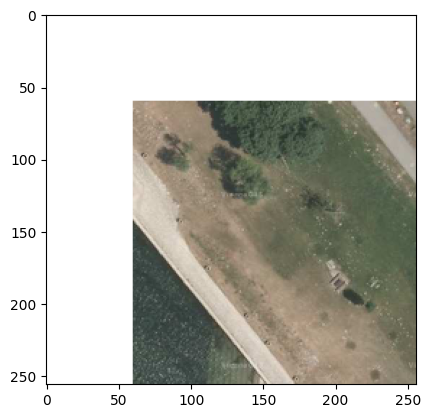

In [25]:
plt.imshow(variable[0])

In [7]:
variable = tf.convert_to_tensor(
    variable
)

In [8]:
variable = tf.image.extract_patches(
    variable,
    sizes = [1, 256, 256, 1],
    strides = [1, 256, 256, 1],
    rates = [1, 1, 1, 1],
    padding = 'VALID'
)
variable = tf.reshape(
    variable,
    shape=(2000, 256, 256, 4)
)
variable = variable/255

In [5]:
dirpath='/home/konrad.horber/code/bergerbastian/inria1358/raw_data/aerial_images_inria1358/AerialImageDataset/train/images'
tensor_batch = []
count = 0

for i in os.listdir(dirpath)
    for filename in os.listdir(dirpath):
        # if count >= 10:
        #     break
        tiff = tf.io.read_file(f'{dirpath}/{filename}')
        tensor = tfio.experimental.image.decode_tiff(tiff)
        chicago1_tensor_pad = tf.pad(tensor, [[60,60], [60,60], [0,0]], mode='CONSTANT', constant_values=-1)
        tensor_batch.append(tensor)
        count += 1


TIFFReadDirectory: Warning, Unknown field with tag 42113 (0xa481) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 42113 (0xa481) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 42113 (0xa481) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 42113 (0xa481) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 42113 (0xa481) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 42113 (0xa481) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 42113 (0xa481) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 42113 (0xa481) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 42113 (0xa481) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 42113 (0xa481) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 42113 (0xa481) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 42113 (0xa481) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 4

In [6]:
tensor_batch = tf.convert_to_tensor(tensor_batch)

2023-09-19 15:14:53.003811: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 18000000000 exceeds 10% of free system memory.


: 

In [4]:
tensor_batch.shape

TensorShape([10, 5000, 5000, 4])

In [ ]:
tf.conver_to_tensor_batch

In [121]:
chicago1 = tf.io.read_file('/home/konrad.horber/code/bergerbastian/inria1358/raw_data/aerial_images_inria1358/AerialImageDataset/train/images/chicago1.tif')

In [127]:
chicago1_tensor = tfio.experimental.image.decode_tiff(
    chicago1
)

In [140]:
chicago1_tensor.__sizeof__()

152

In [128]:
chicago1_tensor.shape

TensorShape([5000, 5000, 4])

In [129]:
chicago1_tensor_pad = tf.pad(chicago1_tensor, [[60,60], [60,60], [0,0]], mode='CONSTANT', constant_values=-1)

In [130]:
chicago1_tensor_pad.shape

TensorShape([5120, 5120, 4])

In [131]:
chicago1_tensor_pad_batch = tf.expand_dims(chicago1_tensor_pad, axis=0)

In [132]:
chicago1_tensor_pad_batch.shape

TensorShape([1, 5120, 5120, 4])

In [133]:
chicago1_tensor_pad_batch_extract = tf.image.extract_patches(
    chicago1_tensor_pad_batch,
    sizes = [1, 256, 256, 1],
    strides = [1, 256, 256, 1],
    rates = [1, 1, 1, 1],
    padding = 'VALID'
)

In [134]:
chicago1_tensor_pad_batch_extract.shape

TensorShape([1, 20, 20, 262144])

In [135]:
chicago1_tensor_pad_batch_extract_reshape = tf.reshape(
    chicago1_tensor_pad_batch_extract,
    shape=(400, 256, 256, 4)
)

In [136]:
chicago1_tensor_pad_batch_extract_reshape_scaled = chicago1_tensor_pad_batch_extract_reshape/255

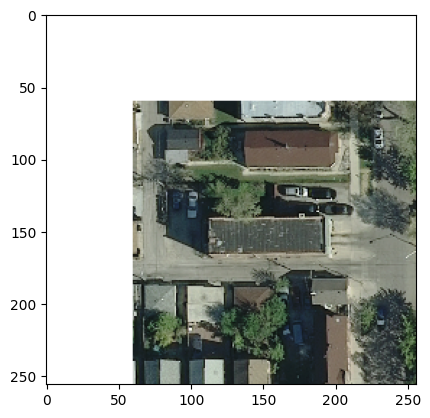

In [139]:
plt.imshow(chicago1_tensor_pad_batch_extract_reshape_scaled[0])

[#images * 20*20, 256, 256, 4]

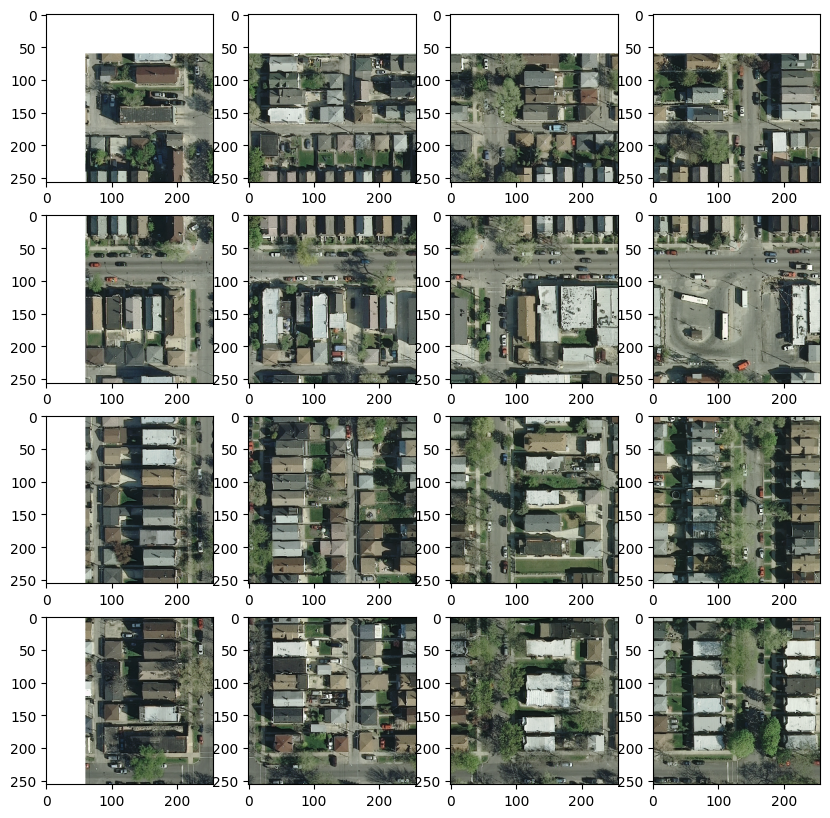

In [87]:
plt.figure(figsize=(10, 10))
for imgs in chicago1_tensor_pad_batch_extract:
    count = 0
    for r in range(4):
        for c in range(4):
            ax = plt.subplot(4, 4, count+1)
            plt.imshow(tf.reshape(imgs[r,c],shape=(256,256,4)).numpy().astype("uint8"))
            count += 1

In [30]:
chicago1_tensor_pad.shape

TensorShape([5120, 5120, 4])

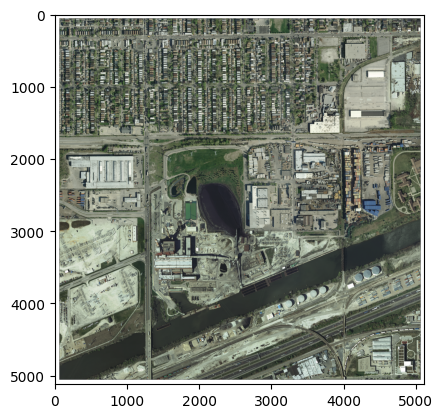

In [31]:
plt.imshow(chicago1_tensor_pad)

In [21]:
chicago1_tensor_pad = tf.keras.layers.ZeroPadding2D(
    padding=(60,60)
)

In [22]:
chicago1_tensor_pad.

AttributeError: 'ZeroPadding2D' object has no attribute 'shape'

In [ ]:
chci

In [8]:
one, two = tf.split(
    chicago1_tensor,
    num_or_size_splits=2,
    axis=0
)

In [10]:
one

TensorShape([2500, 5000, 4])

In [12]:
one_one, one_two = tf.split(
    one,
    num_or_size_splits=2,
    axis=1
)

In [13]:
one_one.shape

TensorShape([2500, 2500, 4])